Goal
==
We are about to train a *sequence-to-sequence model* to predict a paragraph of Gustave Flaubert's *Madame Bovary* given the preceding paragraph.
The model (at least in its first version) does not use words as units of text but characters.

*   The encoder part, based on a bidirectional LSTM, reads an input paragraph and turns it into a set of tensors that serves as initial state for the decoder part.
*   The decoder part is based on an (unidirectional) LSTM. The state of the LSTM is used to compute a probability distribution over the alphabet (including space and punctuation marks) and is updated each time a character is predicted by the LSTM reading this character's embedding.
*   The goal is to get the best model. It is part of the job to define what this means. It is also part of the job to explain me how you get your best model.

This is an assignment.
==

*   Work in groups of two or three students.
*   Due date: December 9th (Monday), 23:59
*   Malus: -1 per day of delay.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Keep in mind all remarks given in previous TPs.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Document all the changes that you make. Any work that is not properly explained can be ignored.

Downloading the dataset
==
The dataset we are going to use is there: https://www.gutenberg.org/cache/epub/14155/pg14155.txt

We have to pre-process it a little bit in order to remove everything that is not part of the text and to split the actual text into paragraphs.

In [ ]:
use_toy_dataset = False # If True, a toy dataset (see below) is used, instead of the "real" one.

In [ ]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt")
filename = tmp[0]
print(filename)

/tmp/tmpnzh9vows


In [ ]:
# Prints the first 200 lines in the file with their line number.
# This shows that we have a little bit of preprocessing to do in order to clean the data.
with open(filename, encoding='utf-8') as f:
  for i in range(200):
    print(f"[{i}] {f.readline()}", end='')

In [ ]:
import re # Regular expression library
roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.

with open(filename, encoding='utf-8') as f:
  # We want to skip everything before the actual text of the novel.
  # The line "PREMIÈRE PARTIE" appears twice: in the table of content and then at the start of the first part of the actual text.
  # The following lines discard everything up to this second occurence (included).
  skip = 2
  while(skip > 0):
    line = f.readline().strip()
    if(line == "PREMIÈRE PARTIE"): skip -= 1;

  paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
  paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
  while(True):
    line = f.readline().strip()
    if("END OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY" in line): break # End of the actual text.

    if(line == ""): # We've reached the end of a paragraph.
      if(len(paragraph_buffer) > 0):
        paragraph_buffer.append(EOP) # End of the paragraph.

        paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
        paragraphs.append(paragraph)
        paragraph_buffer = []
      continue

    if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
    if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

    if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
    paragraph_buffer.append(line)

print(f"{len(paragraphs)} paragraphs read.")
for i in range(3): print(paragraphs[i], end='')

2995 paragraphs read.
Nous étions à l'Étude, quand le Proviseur entra, suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre. Ceux qui dormaient se réveillèrent, et chacun se leva comme surpris dans son travail.
Le Proviseur nous fit signe de nous rasseoir; puis, se tournant vers le maître d'études:
-- Monsieur Roger, lui dit-il à demi-voix, voici un élève que je vous recommande, il entre en cinquième. Si son travail et sa conduite sont méritoires, il passera dans les grands, où l'appelle son âge.


Here, we define a toy dataset on which your model, if correctly implemented, should be able to learn more easily.

In [ ]:
if(use_toy_dataset):
  paragraphs = []

  import random, string
  characters = list(string.ascii_lowercase + string.ascii_lowercase.upper() + "_-/\'[]()")
  random.shuffle(characters)
  k = random.randint(1, 10)
  a = "a"
  paragraph = (a * k)
  for _ in range(100):
    random.shuffle(characters)
    for a in characters:
      k = random.randint(1, 16)
      paragraph += f"? Now, please write {k} {a}.{EOP}"
      paragraphs.append(paragraph)
      paragraph = (a * k)
  print(f"{len(paragraphs)} paragraphs generated.")

  print(paragraphs[:10])

In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
char_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for char in paragraph: char_counts[char] += 1

print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True)) # Shows each character with its frequency, in decreasing frequency order.

In [ ]:
char_counts.keys() # len = 95

dict_keys(['N', 'o', 'u', 's', ' ', 'é', 't', 'i', 'n', 'à', 'l', "'", 'É', 'd', 'e', ',', 'q', 'a', 'P', 'r', 'v', 'h', 'b', 'g', 'ç', 'c', 'p', '.', 'C', 'x', 'm', 'è', '\n', 'L', 'f', ';', 'î', ':', '-', 'M', 'R', 'j', 'S', 'ù', 'â', 'z', 'I', 'Q', 'û', 'ê', 'O', 'y', 'k', 'ï', 'E', 'T', 'U', 'D', '!', '(', ')', 'B', '?', '_', 'G', '1', '8', '2', 'A', 'À', 'H', 'ô', 'V', 'Ê', '«', '»', 'Y', 'F', 'J', 'ë', 'W', 'X', '0', '5', '7', '9', '6', '3', 'w', 'Î', 'Ç', '4', 'ü', '°'])

In [ ]:
# Here you have to build a dictionary 'char_vocabulary' that assigns an integer id to each character, along with a list/array 'id_to_char' that implements the reverse mapping.
#################
def vocabulary(char_counts):
  char_vocabulary = {} #dict[str:int]
  id_to_char = [] # list[str]
  for char in char_counts.keys():
    if char not in char_vocabulary:
      char_vocabulary[char] = len(char_vocabulary)
      id_to_char.append(char)

  return char_vocabulary, id_to_char
#################
char_vocabulary, id_to_char = vocabulary(char_counts)


In [ ]:
EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol
padding_id = EOP_id + 1 # Pseudo-id for the "padding symbol" (which in fact does not exist)

print(char_vocabulary)
print(id_to_char)
print(f"EOP_id = {EOP_id}")

# Here you have to implement a test that proves that your implementations of 'char_vocabulary' and 'id_to_char' are consistent.
#################
print('id of u: ',char_vocabulary['u'])
print('char with id 2: ', id_to_char[2])
print('u expected: ',id_to_char[char_vocabulary['u']]) # we expect to fall back on 'u'. This is indeed 'u' so the implementations are consistent
print('2 expected: ',char_vocabulary[id_to_char[2]]) # we also expect to fall back on 2.
#################

In [ ]:
# Turns a list of lists of ids into a list of strings.
# Do not forget that an occurrence of EOP means that the paragraph ends here.
# ids: list[int] // ids: list[list[int]] (n list[int] for n sentences)
def ids_to_texts(ids):
  # Here you have to turn each list of character ids of 'ids' into a string and then return all strings as a list.
  #################
  texts = [] # list[str]
  for id_seq in ids: # for every id:
    text = [] # list[str] for every id sequence
    for i in id_seq:
      if i == EOP_id: # If the id equals the end of paragraph id, we stop the iteration.
        break
      text.append(id_to_char[i]) # Else, we append the char to text.
    texts.append(''.join(text)) # Finally, we add the text to the list of texts.
  return texts
  ###############

In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}")

[[61, 1, 8, 41, 1, 2, 19, 27], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, padding_id, padding_id]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}") # If you have a problem here, remember that EOP indicates the end of the text (this might be related to your problem).

[[61, 1, 8, 41, 1, 2, 19, 27, 32, 33, 33], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
# A training instance is composed of a pair of consecutive paragraphs. The goal will be to predict the second given the first.
# (Possible improvement: As is, ends of chapter are completely ignored: the last paragraph of a chapter and the first of the following chapter form a training instance. We might want to predict the end of the chapter instead, or simply remove these pairs from the dataset.)
class BatchGenerator:
  # paragraphs: list[str]
  # char_vocabulary: dict[str, int]
  def __init__(self, paragraphs, char_vocabulary):
    self.paragraphs = paragraphs
    self.char_vocabulary = char_vocabulary # Dictionary
    self.padding_idx = len(char_vocabulary)

  # Returns the number of training instances (i.e. of pairs of consecutive paragraphs).
  def length(self):
    return (len(self.paragraphs) - 1)

  # Returns a random training batch (composed of pairs of consecutive paragraphs).
  # batch_size: int
  # subset: int | None; if an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  def get_batch(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())
    paragraph_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some paragraph ids.

    return self._ids_to_batch(paragraph_ids)

  # paragraph_ids: sequence of int·s
  def _ids_to_batch(self, paragraph_ids):
    firsts = [] # list[list[int]]; first paragraph of each pair
    seconds = [] # list[list[int]], second paragraph of each pair
    for paragraph_id in paragraph_ids:
      firsts.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id]])
      seconds.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id + 1]])

    # Padding
    self.pad(firsts)
    self.pad(seconds)

    firsts = torch.tensor(firsts, dtype=torch.long) # Conversion to a tensor
    seconds = torch.tensor(seconds, dtype=torch.long) # Conversion to a tensor

    return (firsts, seconds)

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # Works "in place".
  # sequences: list[list[int]]
  def pad(self, sequences):
    max_length = max([len(s) for s in sequences])
    for s in sequences: s.extend([self.padding_idx] * (max_length - len(s)))

  # Returns a generator of training batches for a full epoch. (Note that this function is not used in the training loop implemented below. `get_batch` is used instead.)
  # batch_size: int
  # subset: int | None; if an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  def all_batches(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(instance_ids)
      i += batch_size

    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(instance_ids)

  # Turns a list of arbitrary paragraphs into a prediction batch.
  # paragraphs: list[str]
  def turn_into_batch(self, paragraphs):
    firsts = [] # list[list[int]]
    for paragraph in paragraphs:
        tmp = [] # list[int]
        for char in paragraph:
          # Unknown characters are ignored (removed).
          if(char in self.char_vocabulary): tmp.append(self.char_vocabulary[char])

        if(tmp[-1] != EOP_id): tmp.append(EOP_id) # Adds an end-of-paragraph character if necessary.

        firsts.append(tmp)

    self.pad(firsts)
    return torch.tensor(firsts, dtype=torch.long)

batch_generator = BatchGenerator(paragraphs=paragraphs, char_vocabulary=char_vocabulary)
print(batch_generator.length())

2994


In [ ]:
(firsts, seconds) = batch_generator.get_batch(3)
print(ids_to_texts(firsts))
print(ids_to_texts(seconds))

["Et elle avait l'air de quelqu'un qui se réveille d'un songe.", '-- Tu es triste, dit Emma.', "-- Moi, à votre place, disait-il, je me libérerais, et j'aurais encore le surplus de l'argent."]
["-- C'est que vous passiez la main sur votre front. J'ai cru qu'un étourdissement vous prenait.", '-- Non, pourquoi?', "Elle objecta la difficulté d'un acquéreur; il donna l'espoir d'en trouver; mais elle demanda comment faire pour qu'elle pût vendre."]


The model
==
For this model, we will not define a `forward` method, but two methods: `trainingLogits` and `predictionStrings`.

*    `trainingLogits` is used at training time, when each batch is split in two parts: input paragraphs and output paragraphs. This function outputs, for each output paragraph of the batch, a log-probability distribution (i.e. a vector of "logits") before each token and after the last one. These distributions depend on the encoding of the corresponding input paragraph. They will then be used to compute a loss value.
*    `predictionStrings` is used at prediction time, when each batch is only composed of input paragraphs. This function outputs, for each input paragraph, a string obtained by decoding the encoding of the paragraph and its probability according to the model.

(Don't forget to read carefully all comments and to make sure that you understand them.)

Here is a graphical representation of the architecture: https://moodle.u-paris.fr/mod/resource/view.php?id=648001
Before starting the implementation, make sure you understand it.

In [ ]:
class Model(torch.nn.Module):
  # size_vocabulary: int; does not include a padding character, but does include the end-of-paragraph one.
  # EOP_id: int
  # embedding_dim: int
  # lstm_hidden_size: int
  # lstm_layers: int
  # device: str
  def __init__(self, size_vocabulary, EOP_id, embedding_dim, lstm_hidden_size, lstm_layers, device='cpu'):
    super().__init__()

    self.device = device

    self.EOP_id = EOP_id # At prediction time, this index is used to stop the generation at the end of the paragraph.

    # Here you have to define:
    #  (i) an embedding layer 'self.char_embeddings' with 'torch.nn.Embedding' for the characters, including an padding embedding;
    #  (ii) a bidirectional LSTM 'self.encoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iii) a unidirectional LSTM 'self.decoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    #  (iv) a network 'self.decoder_initialiser' meant to turn the final hidden and cell states of the encoder into the initial hidden and cell states of the decoder;
    #  (v) a network 'self.distribution_nn' meant to turn the hidden state of the decoder at each step into the logits of a probability distribution over the vocabulary. The logits of a probability distribution are simply the log-probabilities (you might want to use torch.nn.LogSoftmax).
    # Send all parts to 'device', so that we can use a GPU.
    #################

    # (i) Shape: (batch_size, seq_len, embedding_dim)
    self.char_embeddings = torch.nn.Embedding(num_embeddings=size_vocabulary+1, # +1 for the padding token
                                              embedding_dim=embedding_dim,
                                              padding_idx=size_vocabulary).to(self.device)

    # (ii) Outputs: output, (h_n, c_n)
    # output: (batch_size, seq_len, 2*lstm_hidden_size)
    # h_n: (2*lstm_layers, batch_size, lstm_hidden_size)
    # c_n: (2*lstm_layers, batch_size, lstm_hidden_size)
    self.encoder_lstm = torch.nn.LSTM(input_size=embedding_dim,
                                      hidden_size=lstm_hidden_size,
                                      num_layers=lstm_layers,
                                      batch_first=True,
                                      bidirectional=True).to(self.device)

    # (iii) Outputs: output, (h_n, c_n)
    # output: (batch_size, seq_len, lstm_hidden_size)
    # h_n: (lstm_layers, batch_size, lstm_hidden_size)
    # c_n: (lstm_layers, batch_size, lstm_hidden_size)
    self.decoder_lstm = torch.nn.LSTM(input_size=embedding_dim,
                                      hidden_size=lstm_hidden_size,
                                      num_layers=lstm_layers,
                                      batch_first=True).to(self.device)

    # (iv)
    self.decoder_initialiser = torch.nn.Linear(in_features=2 * lstm_hidden_size,
                                               out_features=lstm_hidden_size).to(self.device)

    # (v) Shape: (batch_size, seq_len, vocab_size)
    self.distribution_nn = torch.nn.Sequential(torch.nn.Linear(lstm_hidden_size, size_vocabulary),
                                               torch.nn.LogSoftmax(dim=-1)).to(self.device)
    #################

  # This function encodes the input paragraphs and turns them into initial states for the decoder. It is used both at training and prediction time.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def initStates(self, in_paragraphs):
    batch_size = in_paragraphs.size(0)

    in_char_embeddings = self.char_embeddings(in_paragraphs) # Shape: (batch_size, max length, embedding size)
    #print(in_char_embeddings); print(in_char_embeddings.shape)
    in_lengths = (in_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # Shape: (batch_size)
    #print(in_lengths); print(in_lengths.shape)
    in_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=in_char_embeddings,
                                                                 lengths=in_lengths.cpu(),
                                                                 batch_first=True,
                                                                 enforce_sorted=False) # Enables the biLSTM to ignore padding elements.

    # The input paragraphs are encoded; the final hidden and cell states of the network will be used to initialise the decoder after a little transformation.
    _, (h_n, c_n) = self.encoder_lstm(in_char_embeddings) # 'h_n' and 'c_n' are both of shape (num_layers * 2, batch_size, hidden_size)

    # Concatenates the left-to-right and right-to-left final hidden states of the biLSTM.
    h_n = h_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(h_n); print(h_n.shape)
    lr_h_n = h_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_h_n = h_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_h_n = torch.cat([lr_h_n, rl_h_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_h_n); print(bi_h_n.shape)

    # Concatenates the left-to-right and right-to-left final cell states of the biLSTM.
    c_n = c_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(c_n); print(c_n.shape)
    lr_c_n = c_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_c_n = c_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_c_n = torch.cat([lr_c_n, rl_c_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_c_n); print(bi_c_n.shape)

    # What should be the shape of the two tensors of the following pair? Answer: (num_layers, batch_size, hidden_size)
    return (self.decoder_initialiser(bi_h_n), self.decoder_initialiser(bi_c_n))

  # Training time: This function outputs the logits for each time step.
  # Because at training time, the output paragraph is known, there is no need to generate anything sequentially — all positions can be processed at the same time. In fact, there is a loop hidden in the call to the decoder LSTM, but you should not write any explicit loop here.
  # Do not forget the distribution for the first character.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # 'out_paragraphs' is a matrix (batch size, max out length) of character ids (Integer) at training time.
  # This might include EoS and padding tokens;
  # the corresponding distributions are meaningless/useless and will have to be excluded when computing the loss.
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def trainingLogits(self, in_paragraphs, out_paragraphs):
    decoder_init_states = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    # Feed a packed sequence to the decoder (use 'torch.nn.utils.rnn.pack_padded_sequence' and 'torch.nn.utils.rnn.pad_packed_sequence').
    # You don't need to implement a loop, because at training time, you know in advance the decisions of the system (i.e. the tokens that are generated).
    #################

    # Unpack the initial states
    h_initial, c_initial = decoder_init_states

    # Embed the output paragraphs without the end token.
    # Shape: (batch_size, seq_len-1, embedding_size)
    out_char_embeddings = self.char_embeddings(out_paragraphs[:, :-1])

    # Get the output lengths without the padding token.
    # Shape: (batch_size)
    out_lengths = (out_paragraphs[:, :-1] != self.char_embeddings.padding_idx).sum(axis=1)

    # Pack the padded sequence.
    packed_embeddings = torch.nn.utils.rnn.pack_padded_sequence(
        input=out_char_embeddings,
        lengths=out_lengths.cpu(),
        batch_first=True,
        enforce_sorted=False
    )

    # Decode the packed sequence.
    decoded_packed_embeddings, _ = self.decoder_lstm(
        packed_embeddings,
        (h_initial, c_initial)
    )

    # Pad the packed sequence.
    # Shape: (batch_size, seq_len-1, lstm_hidden_size)
    padded_embeddings, _ = torch.nn.utils.rnn.pad_packed_sequence(
        decoded_packed_embeddings,
        batch_first=True
    )

    # Concatenate the last layer's hidden state, then compute logits.
    # Shape: (batch_size, seq_len, vocab_size)
    logits = self.distribution_nn(torch.cat((h_initial[-1].unsqueeze(1), padded_embeddings), dim=1))

    return logits


    #################

  # Prediction time: This function generates a text up to 'max_predicted_char' character long for each paragraph in the batch, then returns the paragraphs and their log-probabilities.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def predictionStrings(self, in_paragraphs, max_predicted_char=1000):
    h_n, c_n = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    # Decode 'decoder_init_states' into a matrix a character ids (on line per input paragraph in the batch) and then convert it to strings of actual characters.
    # You will need to implement a loop at some point.
    # To work with probability distributions, you may use "torch.distributions.Categorical", but not necessarily.
    # To compute the log-probabilities of the paragraphs generated, at some point you probably need something like `logits.gather(1, next_characters.unsqueeze(1)).squeeze(1)`, evaluating as a float tensor of shape (batch_size).
    #################

    # Initialise the lists of ids and log probs to append on a for loop.
    ids = []
    logprobs = []

    # Generate the first character greedily to generate the following characters starting from this.
    initial_logits = self.distribution_nn(h_n[-1])  # Shape: (batch_size, size_vocabulary)
    initial_char = torch.argmax(initial_logits, dim=1)  # Shape: (batch_size)
    first_log_prob = initial_logits.gather(1, initial_char.unsqueeze(1)).squeeze(1)  # Shape: (batch_size)
    current_char = initial_char.unsqueeze(1) # Shape: (batch_size, 1)

    ids.append(initial_char)
    logprobs.append(first_log_prob)

    # Iterate over the maximum number of predicted characters to generate the text.
    for _ in range(max_predicted_char):
      # Embed the currend character.
      current_char_embedding = self.char_embeddings(current_char) # Shape: (batch_size, 1, embedding_dim)

      # Get the decoder outputs.
      # decoder_output: (batch_size, 1, hidden_size)
      decoder_output, (h_n, c_n) = self.decoder_lstm(
          current_char_embedding,
          (h_n, c_n)
      )

      # Compute the logits
      logits = self.distribution_nn(decoder_output.squeeze(1)) # Shape: (batch_size, size_vocabulary)

      # Greedily select the next character with argmax.
      next_character = torch.argmax(logits, dim=1) # Shape: (batch_size)

      # If all sequences generate EOP, we break the for loop.
      if (next_character == self.EOP_id).all():
        break

      # Compute the logprobs.
      logprob = logits.gather(1, next_character.unsqueeze(1)).squeeze(1) # shape: (batch_size)

      # Append the lists, and update the current character.
      ids.append(next_character)
      logprobs.append(logprob)
      current_char = next_character.unsqueeze(1)

    # Concatenate the ids, and get texts, logprobs.
    ids = torch.stack(ids, dim=1) # Shape: (batch_size, seq_len)
    texts = ids_to_texts(ids.cpu().numpy()) # List[str]
    logprobs = torch.stack(logprobs, dim=1).sum(dim=1) # Tensor[batch_size]

    #################

    return texts, logprobs # List[str], Tensor[float]


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=19, lstm_hidden_size=13, lstm_layers=7, device=device)

In [ ]:
# Tests the training method.
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 0))]).to(model.device) # A batch that contains only one sentence with no padding.
print(in_paragraphs)

out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(f"logits:\n{logits}\n")

In [ ]:
# Checks that a tensor is a tensor of logits, i.e. that each vector is a vector of log-probabilities.
def check_logits(logits):
  # This function should return True iff `logits` is a tensor of logits (False otherwise).
  #################
  # Compute exp(logits) to get probs back.
  probs = torch.exp(logits)
  # Sum the probs. A tensor of logits should sum to 1.
  probs_sum = probs.sum(dim=-1)
  # Check if probs_sum equals to a vector of ones.
  return torch.allclose(probs_sum, torch.ones_like(probs_sum))
  #################

print(f"The following should be True: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.6, 2.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.9]])))}")

The following should be True: True
The following should be False: False
The following should be False: False
The following should be False: False


In [ ]:
print(f"The following should be True: {check_logits(logits)}")

The following should be True: True


In [ ]:
# Tests the training method (again).
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 10)), (list(range(10)) + ([batch_generator.padding_idx] * 5))]).to(model.device) # A batch that contains two sentences with some padding (more than necessary).
print(in_paragraphs)
out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(logits)

print(f"The following should be True: {check_logits(logits)}")

tensor([[ 0,  1,  2,  3,  4, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 94, 94, 94, 94, 94]],
       device='cuda:0')
tensor([[[-4.6087, -4.7270, -4.2476,  ..., -4.5359, -4.6967, -4.3940],
         [-4.7148, -4.7071, -4.2730,  ..., -4.5280, -4.7069, -4.4373],
         [-4.7458, -4.6978, -4.2664,  ..., -4.5298, -4.7224, -4.4483],
         ...,
         [-4.5992, -4.7816, -4.3508,  ..., -4.4831, -4.5901, -4.5137],
         [-4.5992, -4.7816, -4.3508,  ..., -4.4831, -4.5901, -4.5137],
         [-4.5992, -4.7816, -4.3508,  ..., -4.4831, -4.5901, -4.5137]],

        [[-4.6118, -4.7250, -4.2445,  ..., -4.5371, -4.7028, -4.3913],
         [-4.7174, -4.7051, -4.2708,  ..., -4.5290, -4.7106, -4.4350],
         [-4.7476, -4.6963, -4.2651,  ..., -4.5306, -4.7246, -4.4468],
         ...,
         [-4.7769, -4.6768, -4.2640,  ..., -4.5308, -4.7439, -4.4817],
         [-4.7770, -4.6763, -4.2640,  ..., -4.5307, -4.7440, -4.4825],
         [-4.7771, -4.67

In [ ]:
# Tests the prediction methods.
batch = batch_generator.get_batch(2)
model.predictionStrings(batch[0].to(model.device), max_predicted_char=16)

(['MMMMMMMMMMMMMMMMM', 'MMMMMMMMMMMMMMMMM'],
 tensor([-71.0559, -71.0560], device='cuda:0', grad_fn=<SumBackward1>))

Training
==

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=256, lstm_hidden_size=512, lstm_layers=1, device=device)

import time

model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).

# Training procedure
learning_rate = 0.2
momentum = 0.99
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
batch_size = 64 if(not use_toy_dataset) else 128
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length() if(subset is None) else subset # In number of instances

nb_epoch = 50 if(not use_toy_dataset) else 1
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
train_loss = [] # Will contain the train loss for every epoch
durations = [] # Will contain the computation time for every epoch
time_0 = time.time()
while(epoch_id < nb_epoch):
  model.train() # Tells Pytorch we are in training mode (can be useful if dropout is used, for instance).

  model.zero_grad() # Makes sure the gradient is reinitialised to zero.

  batch = batch_generator.get_batch(batch_size, subset=subset)
  #print(ids_to_texts(batch[0])); print(ids_to_texts(batch[1]))
  in_paragraphs = batch[0].to(model.device)
  out_paragraphs = batch[1].to(model.device)

  # You have to (i) compute the prediction of the model, (ii) compute the loss, (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
  # For the loss, use torch.nn.functional.nll_loss. Computes an average over all tokens of the batch, but do not take into account distribution logits that corresonds to padding characters. Read the documentation and be careful about the shape of your tensors.
  # TAKE THIS COMMENT EXTRA-SERIOUSLY: If you have a problem of unmatching length, consider a batch of size 1 and represent in details on paper what is in `out_paragraphs`, what is output by `trainingLogits`, and what the loss function computes; there is probably an additional meaningless item somewhere (or maybe something is missing).
  ###################
  preds = model.trainingLogits(in_paragraphs, out_paragraphs) # Shape: (batch_size, seq_len, vocab_size)
  # Reshape the predictions to compute the loss.
  reshaped_preds = preds.view(-1, len(char_vocabulary)) # Shape: (batch_size * seq_len, vocab_size)
  targets = out_paragraphs.view(-1) # Shape: (batch_size * seq_len)

  loss = torch.nn.functional.nll_loss(
      input=reshaped_preds,
      target=targets,
      ignore_index=batch_generator.padding_idx,
      reduction='mean'
  )

  loss.backward()
  epoch_loss.append(loss)
  ###################

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size):
    print(f"-- END OF EPOCH {epoch_id}.")
    average_loss = sum(epoch_loss) / len(epoch_loss)
    train_loss.append(average_loss) # Append the list of average losses.
    print(f"Average loss: {average_loss.item()}.")
    duration = time.time() - time_0
    durations.append(duration)
    print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")

    # Example of generation
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      batch = batch_generator.get_batch(1, subset=subset)
      print(ids_to_texts(batch[0])) # Input paragraph
      print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=512)) # Generated output paragraph.

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

-- END OF EPOCH 0.
Average loss: 2.911120653152466.
24.010555505752563 s elapsed (i.e. 24.010555505752563 s/epoch)
["-- Ni moi! reprit vivement M. Homais, quoiqu'il lui faudra pourtant suivre les autres, au risque de passer pour un jésuite. Et vous ne savez pas la vie que mènent ces farceurs-là, dans le quartier Latin, avec les actrices! Du reste, les étudiants sont fort bien vus à Paris. Pour peu qu'ils aient quelque talent d'agrément, on les reçoit dans les meilleures sociétés, et il y a même des dames du faubourg Saint-Germain qui en deviennent amoureuses, ce qui leur fournit, par la suite, les occasions de faire de très beaux mariages."]
(['--- le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le l

In [ ]:
with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
  if(use_toy_dataset):
    prompt = ["AAAA. Now, please write 3 i." + EOP] #[paragraphs[0]]
    print(prompt[0])
    print(f"(Is this prompt in the training set? {prompt[0] in paragraphs})\n")

    for _ in range(10):
      batch = batch_generator.turn_into_batch(prompt)
      gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=128)

      print(f"{gen_texts[0]} (log-probability: {logprobs.item()})")
      prompt = [gen_texts[0] + EOP]
  else:
    prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
    batch = batch_generator.turn_into_batch(prompt)
    gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

    print(prompt[0])
    print()
    for i, (gen_text, logprob) in enumerate(zip(gen_texts, logprobs)):
      print(f"{i}: ", end="")
      print(gen_text)
      print(f"log-probability: {logprob.item()}")

Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités.

0: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
1: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
2: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
3: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
4: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
5: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219722747802734
6: -- Ah! ne son père que je ne sais pas, mon ami, il a des extraordinaires de l'autre chose.
log-probability: -50.219

If your system does not work as expected, check that you are using a sensible loss function, but also check that your implementation matches the architecture depicted in https://moodle.u-paris.fr/mod/resource/view.php?id=648001.

**Even if you think that your model learns well, check that it really works on the toy dataset.** If you cannot get perfect results there, then there must be a bug somewhere.

Read the remarks at the beginning of the TP again, and remember the relevant ones from previous TPs.

Once you are sure that your system is correctly implemented and generates texts that look a little bit like natural language, find ways to improve the system.
Here are some ideas (ordered arbitrarily):

*   Use graphs to visualise the training process and the predictions.
*   Compute a measure that evaluates the performance of the model.
*   Split your dataset into a training and a development section, and use this split in a relevant way.
*   Implement beam decoding instead of greedy decoding. (Greedy decoding multiple input paragraphs at the same time is very challenging; do not try this before achieving the greedy decoding of a single input paragraph. Even for a single input paragraph, the task is pretty challenging, so do not try if you are not CERTAIN that everything else works perfectly.)
*   Use other units of text instead of characters (ex: words, word-pieces).
*   Add more data to the dataset.

Document in a text cell all of the changes that you make to the system and describe their impact (qualitatively **and** quantitatively). There is no point on implementing a possible improvement if you do not discuss whether in the end it improves the system or not.

# Plot the training process

In [ ]:
import matplotlib.pyplot as plt

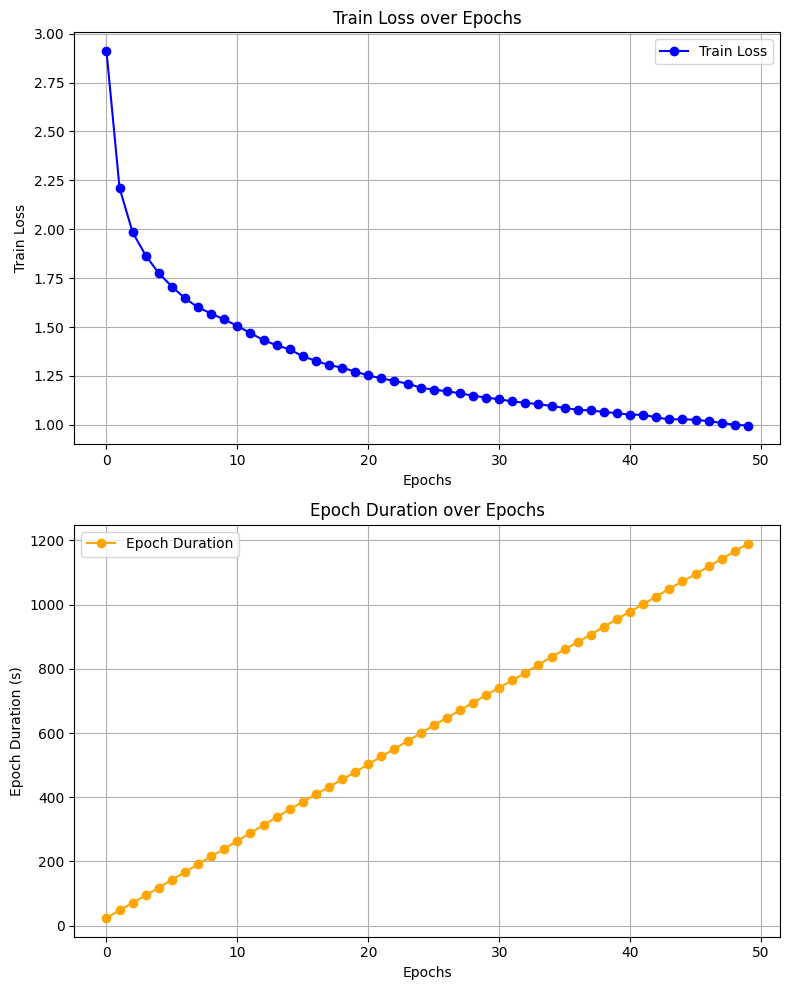

In [ ]:
train_loss = [loss.detach().cpu().item() for loss in train_loss]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot train_loss
ax1.plot(range(nb_epoch), train_loss, marker='o', color='blue', label='Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')
ax1.set_title('Train Loss over Epochs')
ax1.grid(True)
ax1.legend()

# Plot durations
ax2.plot(range(nb_epoch), durations, marker='o', color='orange', label='Epoch Duration')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Epoch Duration (s)')
ax2.set_title('Epoch Duration over Epochs')
ax2.grid(True)
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Adding more data to the dataset

We will use another novel written by Flaubert.

L'Education Sentimentale: https://www.gutenberg.org/cache/epub/49773/pg49773.txt

   
    

In [ ]:
# Download the datasets
import urllib.request

tmp1 = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt") # Madame Bovary
tmp2 = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/49773/pg49773.txt") # L'Education Sentimentale
filename1 = tmp1[0]
filename2 = tmp2[0]
print(filename1, filename2)

/tmp/tmp17tb2h55 /tmp/tmpc7avytkh


In [ ]:
# Function get_paragraph for Madame Bovary

import re

def get_paragraphs(filename):
  roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

  EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.

  with open(filename, encoding='utf-8') as f:
    # We want to skip everything before the actual text of the novel.
    # The line "PREMIÈRE PARTIE" appears twice: in the table of content and then at the start of the first part of the actual text.
    # The following lines discard everything up to this second occurence (included).
    skip = 2
    while(skip > 0):
      line = f.readline().strip()
      if(line == "PREMIÈRE PARTIE"): skip -= 1;

    paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
    paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
    while(True):
      line = f.readline().strip()
      if("END OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY" in line): break # End of the actual text.

      if(line == ""): # We've reached the end of a paragraph.
        if(len(paragraph_buffer) > 0):
          paragraph_buffer.append(EOP) # End of the paragraph.

          paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
          paragraphs.append(paragraph)
          paragraph_buffer = []
        continue

      if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
      if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

      if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
      paragraph_buffer.append(line)

  return paragraphs

In [ ]:
# Function get_paragraph2 for L'Education Sentimentale

# same as get_paragraph except "skip = 1" (instead of skip = 2, because L'Education Sentimentale doesn't have a table of contents with 'PREMIERE PARTIE' compared to Mme Bovary)

import re

def get_paragraphs2(filename):
  roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

  EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.

  with open(filename, encoding='utf-8') as f:
    # We want to skip everything before the actual text of the novel.
    skip = 1
    while(skip > 0):
      line = f.readline().strip()
      if(line == "PREMIÈRE PARTIE"): skip -= 1;

    paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
    paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
    while(True):
      line = f.readline().strip()
      if("END OF THE PROJECT GUTENBERG EBOOK ŒUVRES COMPLÈTES DE GUSTAVE FLAUBERT, TOME 3: L'ÉDUCATION SENTIMENTALE, V. 1" in line): break # End of the actual text.

      if(line == ""): # We've reached the end of a paragraph.
        if(len(paragraph_buffer) > 0):
          paragraph_buffer.append(EOP) # End of the paragraph.

          paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
          paragraphs.append(paragraph)
          paragraph_buffer = []
        continue

      if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
      if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

      if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
      paragraph_buffer.append(line)

  return paragraphs

In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
def count_characters(paragraphs):
  char_counts = collections.defaultdict(int)
  for paragraph in paragraphs:
    for char in paragraph: char_counts[char] += 1

  return char_counts

In [ ]:
para2 = get_paragraphs2(filename2)
print(f"{len(para2)} paragraphs read.")
for i in range(3): print(para2[i], end='')

2237 paragraphs read.
L'ÉDUCATION SENTIMENTALE
Le 15 septembre 1840, vers six heures du matin, _la Ville-de-Montereau_, près de partir, fumait à gros tourbillons devant le quai Saint-Bernard.
Des gens arrivaient hors d'haleine; des barriques, des câbles, des corbeilles de linge gênaient la circulation; les matelots ne répondaient à personne; on se heurtait; les colis montaient entre les deux tambours, et le tapage s'absorbait dans le bruissement de la vapeur, qui, s'échappant par des plaques de tôle, enveloppait tout d'une nuée blanchâtre, tandis que la cloche, à l'avant, tintait sans discontinuer.


In [ ]:
# Concatenation of the two datasets

paragraphs = get_paragraphs(filename1) + get_paragraphs2(filename2)
print(f"{len(paragraphs)} paragraphs read.")

char_counts = count_characters(paragraphs)
print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True))

5232 paragraphs read.
99 different characters found in the dataset.
[(' ', 173364), ('e', 121251), ('a', 71398), ('s', 68661), ('t', 61977), ('i', 61887), ('n', 57583), ('r', 56262), ('u', 52902), ('l', 52342), ('o', 43643), ('d', 31231), ('c', 23899), ('m', 23038), ('p', 21746), (',', 19662), ('é', 14138), ('v', 13200), ("'", 11676), ('.', 9920), ('b', 8944), ('f', 8654), ('h', 8317), ('q', 8114), ('g', 7676), ('-', 5895), ('\n', 5232), ('à', 4148), ('x', 3671), ('è', 2743), ('j', 2726), ('!', 2678), ('y', 2438), (';', 2420), ('E', 2038), ('ê', 1829), ('L', 1543), ('M', 1532), ('C', 1479), ('I', 1434), ('A', 1389), ('z', 1183), ('?', 952), ('«', 864), ('»', 844), (':', 840), ('D', 830), ('P', 821), ('ç', 769), ('â', 648), ('F', 631), ('S', 581), ('B', 548), ('R', 537), ('î', 522), ('O', 504), ('ô', 469), ('ù', 416), ('J', 396), ('Q', 381), ('H', 375), ('T', 369), ('V', 353), ('û', 341), ('N', 271), ('U', 267), ('_', 222), ('G', 105), ('(', 101), (')', 101), ('œ', 96), ('À', 84), ('Y',

In [ ]:
# we put back the functions (already made before) here

# As a reminder, we made a vocabulary function (returning char_vocab and id_to_char), and a ids_to_text function

char_vocabulary, id_to_char = vocabulary(char_counts)

EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol
padding_id = EOP_id + 1 # Pseudo-id for the "padding symbol" (which in fact does not exist)

print(char_vocabulary)
print(id_to_char)
print(f"EOP_id = {EOP_id}")


ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, padding_id, padding_id]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}") # If you have a problem here, remember that EOP indicates the end of the text (this might be related to your problem).

{'N': 0, 'o': 1, 'u': 2, 's': 3, ' ': 4, 'é': 5, 't': 6, 'i': 7, 'n': 8, 'à': 9, 'l': 10, "'": 11, 'É': 12, 'd': 13, 'e': 14, ',': 15, 'q': 16, 'a': 17, 'P': 18, 'r': 19, 'v': 20, 'h': 21, 'b': 22, 'g': 23, 'ç': 24, 'c': 25, 'p': 26, '.': 27, 'C': 28, 'x': 29, 'm': 30, 'è': 31, '\n': 32, 'L': 33, 'f': 34, ';': 35, 'î': 36, ':': 37, '-': 38, 'M': 39, 'R': 40, 'j': 41, 'S': 42, 'ù': 43, 'â': 44, 'z': 45, 'I': 46, 'Q': 47, 'û': 48, 'ê': 49, 'O': 50, 'y': 51, 'k': 52, 'ï': 53, 'E': 54, 'T': 55, 'U': 56, 'D': 57, '!': 58, '(': 59, ')': 60, 'B': 61, '?': 62, '_': 63, 'G': 64, '1': 65, '8': 66, '2': 67, 'A': 68, 'À': 69, 'H': 70, 'ô': 71, 'V': 72, 'Ê': 73, '«': 74, '»': 75, 'Y': 76, 'F': 77, 'J': 78, 'ë': 79, 'W': 80, 'X': 81, '0': 82, '5': 83, '7': 84, '9': 85, '6': 86, '3': 87, 'w': 88, 'Î': 89, 'Ç': 90, '4': 91, 'ü': 92, '°': 93, 'œ': 94, 'Z': 95, 'æ': 96, 'Ï': 97, '*': 98}
['N', 'o', 'u', 's', ' ', 'é', 't', 'i', 'n', 'à', 'l', "'", 'É', 'd', 'e', ',', 'q', 'a', 'P', 'r', 'v', 'h', 'b', '

Batch generator

In [ ]:
# The BatchGenerator class is defined above.
batch_generator = BatchGenerator(paragraphs=paragraphs, char_vocabulary=char_vocabulary)
print(batch_generator.length())

5231


Training

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=256, lstm_hidden_size=512, lstm_layers=1, device=device)

import time

model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).

# Training procedure
learning_rate = 0.2
momentum = 0.99
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
batch_size = 64 if(not use_toy_dataset) else 128
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length() if(subset is None) else subset # In number of instances

nb_epoch = 50 if(not use_toy_dataset) else 1
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
new_train_loss = [] # Will contain the train loss for every epoch
new_durations = [] # Will contain the computation time for every epoch
time_0 = time.time()
while(epoch_id < nb_epoch):
  model.train() # Tells Pytorch we are in training mode (can be useful if dropout is used, for instance).

  model.zero_grad() # Makes sure the gradient is reinitialised to zero.

  batch = batch_generator.get_batch(batch_size, subset=subset)
  #print(ids_to_texts(batch[0])); print(ids_to_texts(batch[1]))
  in_paragraphs = batch[0].to(model.device)
  out_paragraphs = batch[1].to(model.device)

  # You have to (i) compute the prediction of the model, (ii) compute the loss, (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
  # For the loss, use torch.nn.functional.nll_loss. Computes an average over all tokens of the batch, but do not take into account distribution logits that corresonds to padding characters. Read the documentation and be careful about the shape of your tensors.
  # TAKE THIS COMMENT EXTRA-SERIOUSLY: If you have a problem of unmatching length, consider a batch of size 1 and represent in details on paper what is in `out_paragraphs`, what is output by `trainingLogits`, and what the loss function computes; there is probably an additional meaningless item somewhere (or maybe something is missing).
  ###################
  preds = model.trainingLogits(in_paragraphs, out_paragraphs) # Shape: (batch_size, seq_len, vocab_size)
  # Reshape the predictions to compute the loss.
  reshaped_preds = preds.view(-1, len(char_vocabulary)) # Shape: (batch_size * seq_len, vocab_size)
  targets = out_paragraphs.view(-1) # Shape: (batch_size * seq_len)

  loss = torch.nn.functional.nll_loss(
      input=reshaped_preds,
      target=targets,
      ignore_index=batch_generator.padding_idx,
      reduction='mean'
  )

  loss.backward()
  epoch_loss.append(loss)
  ###################

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size):
    print(f"-- END OF EPOCH {epoch_id}.")
    average_loss = sum(epoch_loss) / len(epoch_loss)
    new_train_loss.append(average_loss) # Append the list of average losses.
    print(f"Average loss: {average_loss.item()}.")
    duration = time.time() - time_0
    new_durations.append(duration)
    print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")

    # Example of generation
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      batch = batch_generator.get_batch(1, subset=subset)
      print(ids_to_texts(batch[0])) # Input paragraph
      print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=512)) # Generated output paragraph.

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

-- END OF EPOCH 0.
Average loss: 2.6686596870422363.
38.54556679725647 s elapsed (i.e. 38.54556679725647 s/epoch)
['-- Non, tu te trompes!']
(['-- le la pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les pour les '], tensor([-549.4358], device='cuda:0'))
-- END OF EPOCH 1.
Average loss: 2.018890142440796.
76.48845148086548 s elapsed (i.e. 38.24422574043274 s/epoch)
['-- Cherchez-vous quelque chose? demanda-t-elle.']
(['-- Il se de la comme de la comme de la comme de la comme de la comme de la comme de la comme de la comme de la comme de la comme de l

In [ ]:
with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
  if(use_toy_dataset):
    prompt = ["AAAA. Now, please write 3 i." + EOP] #[paragraphs[0]]
    print(prompt[0])
    print(f"(Is this prompt in the training set? {prompt[0] in paragraphs})\n")

    for _ in range(10):
      batch = batch_generator.turn_into_batch(prompt)
      gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=128)

      print(f"{gen_texts[0]} (log-probability: {logprobs.item()})")
      prompt = [gen_texts[0] + EOP]
  else:
    prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
    batch = batch_generator.turn_into_batch(prompt)
    gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

    print(prompt[0])
    print()
    for i, (gen_text, logprob) in enumerate(zip(gen_texts, logprobs)):
      print(f"{i}: ", end="")
      print(gen_text)
      print(f"log-probability: {logprob.item()}")

Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités.

0: -- Eh bien, je vous assure, dit le pharmacien, et les premiers mois s'écriant à l'autre jour, comme un cheval de caline avec un autre bourgeois qui s'en allait.
log-probability: -99.94194030761719
1: -- Eh bien, je vous assure, dit le pharmacien, et les premiers mois s'écriant à l'autre jour, comme un cheval de caline avec un autre bourgeois qui s'en allait.
log-probability: -99.94194030761719
2: -- Eh bien, je vous assure, dit le pharmacien, et les premiers mois s'écriant à l'autre jour, comme un cheval de caline avec un autre bourgeois qui s'en allait.
log-probability: -99.94194030761719
3: -- Eh bien, je vous assure, dit le pharmacien, et les premiers mois s'écriant à l'autre jour, comme un cheval de caline avec un autre bourgeois qui s'en allait.
log-probability: -99.94194030761719
4: -- Eh bien, je vous assure, dit le pharmacien, et les premiers mois s'écriant à l'autre jour, comme u

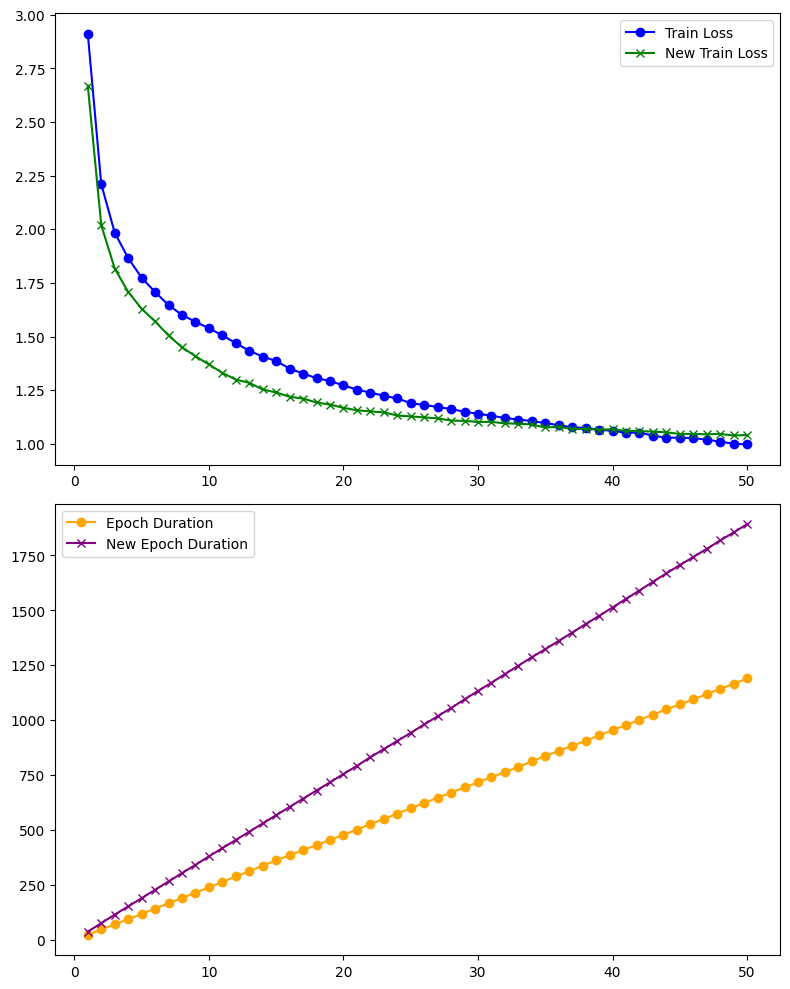

In [ ]:
new_train_loss = [loss.detach().cpu().item() for loss in new_train_loss]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(range(1, nb_epoch + 1), train_loss, marker='o', color='blue', label='Train Loss')
ax2.plot(range(1, nb_epoch + 1), durations, marker='o', color='orange', label='Epoch Duration')

ax1.plot(range(1, nb_epoch + 1), new_train_loss, marker='x', color='green', label='New Train Loss')
ax2.plot(range(1, nb_epoch + 1), new_durations, marker='x', color='purple', label='New Epoch Duration')

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

We can see that adding data requires much more computing time. However, we can also see that the loss goes down faster towards 1.25.